In [ ]:
#run this command to install required libraries
#pip install -r requirements.txt

In [1]:
import pickle
import cProfile
import pstats
import os

In [2]:
current_directory = os.getcwd()  # Get the current working directory
parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
print("Parent Directory:", parent_directory)

Parent Directory: C:\Users\Administrator.DESKTOP-D3SVMI5\Desktop\Hybrid SEIR  Modeling\PySeirCity_Hybrid_deterministic_V11


In [3]:
# Load serialized data 
with open(parent_directory+'\\data\\dates.pkl', 'rb') as file:
    dates = pickle.load(file)
    
with open(parent_directory+'\\data\\facility_date_time_step_urbano_agent_dic.pkl', 'rb') as file:
    facility_date_time_step_urbano_agent_dic = pickle.load(file)
with open(parent_directory+'\\data\\urbano_agent_date_time_step_facility_dic.pkl', 'rb') as file:
    urbano_agent_date_time_step_facility_dic = pickle.load(file)
    
with open(parent_directory+'\\data\\urbano_agents_travelers_mapping.pkl', 'rb') as file:
    urbano_agents_travelers_mapping = pickle.load(file)
with open(parent_directory+'\\data\\traveler_urbano_agent_mapping.pkl', 'rb') as file:
    traveler_urbano_agent_mapping = pickle.load(file)
    
with open(parent_directory+'\\data\\time_use_baseline_dict.pkl', 'rb') as file:
    time_use_baseline_dict = pickle.load(file)
with open(parent_directory+'\\data\\county_mobility_changes_dict.pkl', 'rb') as file:
    county_mobility_changes_dict = pickle.load(file)
with open(parent_directory+'\\data\\stationary_distributions.pkl', 'rb') as file:
    stationary_distributions = pickle.load(file)
with open(parent_directory+'\\data\\facility_to_index.pkl', 'rb') as file:
    facility_to_index = pickle.load(file)

In [4]:
from facility import Facility
from megaagent import State, MegaAgent

from seirstat import Statistics
from preprocessing import SimulationPeriodBasicInfo
from parameters import Parameters, VariedInfectionDurationResponse
from interventions import GeneralTesting, ContactTracing
from simulation import Simulation

G:\Anaconda\envs\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Debug

In [9]:
repetitions = 1
initial_exposed_count = 50
# discount percentage of hazard brought by an asymptomatic individual
asym_hazard_multiplier = 0.5

parameters = Parameters(repetitions, initial_exposed_count, asym_hazard_multiplier)
parameters.infection_duration = VariedInfectionDurationResponse(rate_from_S_to_E=5,
                                                             rate_from_E_to_I=1/3.5, 
                                                             rate_from_asymI_to_R=1/4, 
                                                             rate_from_symI_to_R=1/4, 
                                                             asym_fraction=0, 
                                                             asym_hazard_multiplier=asym_hazard_multiplier)


# Create simulation_period_basic_info object
simulation_period_basic_info = SimulationPeriodBasicInfo(dates,
                                                      facility_date_time_step_urbano_agent_dic,
                                                      urbano_agent_date_time_step_facility_dic,
                                                      urbano_agents_travelers_mapping,
                                                      traveler_urbano_agent_mapping,
                                                      time_use_baseline_dict,
                                                      county_mobility_changes_dict,
                                                      stationary_distributions,
                                                      facility_to_index)

In [13]:
# Create all Facility objects
all_facilities_objects = {}
for f_name in simulation_period_basic_info.AllFacilityNames:
    facility_object = Facility(f_name, simulation_period_basic_info)
    all_facilities_objects[f_name] = facility_object


# Create all MegaAgents
all_mega_agents = {}
for MegaAgentName in simulation_period_basic_info.mega_agent_Urbano_mapping.keys():
    travelers_in_mega_agent = simulation_period_basic_info.MegaAgent_Travelers[MegaAgentName]   
    if travelers_in_mega_agent==0:
        continue
        
    mega_agent = MegaAgent(MegaAgentName,travelers_in_mega_agent,simulation_period_basic_info)
    all_mega_agents[MegaAgentName] = mega_agent

# initialize Statistics
stat = Statistics(all_mega_agents, dates)

In [14]:
%%time
with cProfile.Profile() as pr: 

    for _ in range(repetitions):
    #     initial_exposure = np.random.choice(list(simulation_period_basic_info.AllTravelers), 
    #                                         replace = False, 
    #                                         size = parameters.initial_exposed_count)
        initial_exposure = list(simulation_period_basic_info.AllTravelers)[:parameters.initial_exposed_count]

        for mega_agent_name, mega_agent in all_mega_agents.items():
            if mega_agent.MegaAgentPopulation == 0:
                continue

            if not mega_agent.MegaAgentState.S_travelers.isdisjoint(initial_exposure):
                initial_exposed_travelers_in_mega_agent = mega_agent.MegaAgentState.S_travelers.intersection(initial_exposure)
            else:
                continue

            first_date = dates[0]
            mega_agent.dynamic_time_spent_dic = mega_agent.get_dynamic_time_spent(first_date)
            mega_agent.labelTravelsAsExposed(first_date, 
                                             1,
                                             all_facilities_objects, 
                                             initial_infected=initial_exposed_travelers_in_mega_agent)
            mega_agent.if_initialized = True


        for date in dates:
            print(date)

            # On each day, at the first time step, calculate dynamic time spent for each travelers
            for mega_agent_name, mega_agent in all_mega_agents.items():
                if mega_agent.if_initialized == True and date == dates[0]:
                    continue
                mega_agent.dynamic_time_spent_dic = mega_agent.get_dynamic_time_spent(date)

            for time_step in range(1,7):
                for f_name, f in all_facilities_objects.items():
                    f.FacilityHazard = f.computeFacilityHazard0(date,
                                                                time_step,
                                                                all_mega_agents, 
                                                                parameters, 
                                                                simulation_period_basic_info)
    #                 #print(f.FacilityHazard)

                for mega_agent_name, mega_agent in all_mega_agents.items():
                    if mega_agent.MegaAgentPopulation == 0:
                        continue

                    if mega_agent.if_initialized == True and date == dates[0] and time_step == 1:
                        continue
                    else:
                        mega_agent.labelTravelsAsExposed(date, 
                                                         time_step,
                                                         all_facilities_objects)

                        if len(mega_agent.MegaAgentState.S_travelers) == 0:
                            continue            

    #                     print(str(mega_agent.MegaAgentName) + \
    #                           ": S_population: " + str(len(mega_agent.MegaAgentState.S_travelers)) +\
    #                           ", Risk: " + str(mega_agent.Risk))


            # daily update 
            for mega_agent_name, mega_agent in all_mega_agents.items():
                if mega_agent.MegaAgentPopulation == 0:
                    continue

                mega_agent.MegaAgent_daily_update(date, parameters) 
                mega_agent.record_daily_stat(date, stat)


2022-01-01 00:00:00
2022-01-02 00:00:00
2022-01-03 00:00:00
2022-01-04 00:00:00
2022-01-05 00:00:00
2022-01-06 00:00:00
2022-01-07 00:00:00
2022-01-08 00:00:00
2022-01-09 00:00:00
2022-01-10 00:00:00
2022-01-11 00:00:00
2022-01-12 00:00:00
2022-01-13 00:00:00
2022-01-14 00:00:00
2022-01-15 00:00:00
2022-01-16 00:00:00
2022-01-17 00:00:00
2022-01-18 00:00:00
2022-01-19 00:00:00
2022-01-20 00:00:00
2022-01-21 00:00:00
2022-01-22 00:00:00
2022-01-23 00:00:00
2022-01-24 00:00:00
2022-01-25 00:00:00
2022-01-26 00:00:00
2022-01-27 00:00:00
2022-01-28 00:00:00
2022-01-29 00:00:00
2022-01-30 00:00:00
2022-01-31 00:00:00
2022-02-01 00:00:00
2022-02-02 00:00:00
2022-02-03 00:00:00
2022-02-04 00:00:00
2022-02-05 00:00:00
2022-02-06 00:00:00
2022-02-07 00:00:00
2022-02-08 00:00:00
2022-02-09 00:00:00
2022-02-10 00:00:00
2022-02-11 00:00:00
2022-02-12 00:00:00
2022-02-13 00:00:00
2022-02-14 00:00:00
CPU times: total: 51.6 s
Wall time: 51.6 s


In [15]:
st = pstats.Stats(pr)
st.sort_stats(pstats.SortKey.TIME)
st.print_stats()

         88244375 function calls in 51.193 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    50727   16.050    0.000   16.053    0.000 C:\Users\Administrator.DESKTOP-D3SVMI5\Desktop\Hybrid SEIR  Modeling\PySeirCity_Hybrid_deterministic_V11\SEIRCityModeling\megaagent.py:139(calculate_MegaAgent_risk)
   272160   15.321    0.000   16.500    0.000 C:\Users\Administrator.DESKTOP-D3SVMI5\Desktop\Hybrid SEIR  Modeling\PySeirCity_Hybrid_deterministic_V11\SEIRCityModeling\facility.py:66(computeFacilityHazard0)
    50727    6.689    0.000    7.010    0.000 C:\Users\Administrator.DESKTOP-D3SVMI5\Desktop\Hybrid SEIR  Modeling\PySeirCity_Hybrid_deterministic_V11\SEIRCityModeling\megaagent.py:155(calculate_susceptible_travelers_risks)
    56700    4.938    0.000   32.354    0.001 C:\Users\Administrator.DESKTOP-D3SVMI5\Desktop\Hybrid SEIR  Modeling\PySeirCity_Hybrid_deterministic_V11\SEIRCityModeling\megaagent.py:228(labelTravelsAsExpos

Average final exposure count is 97811.0


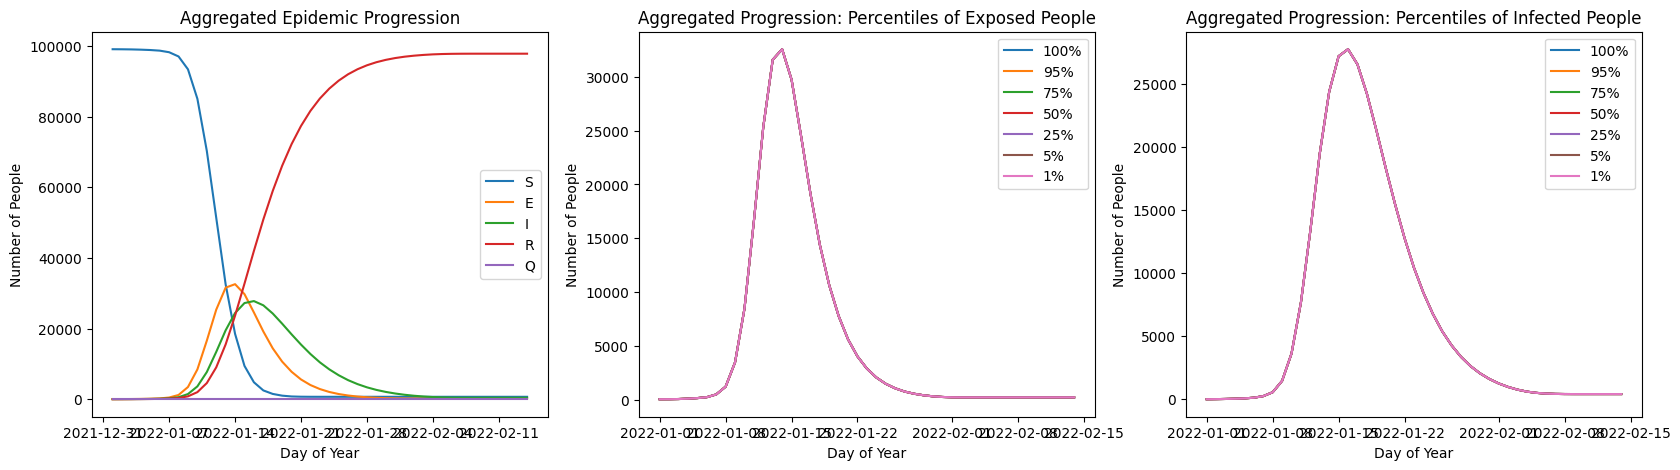

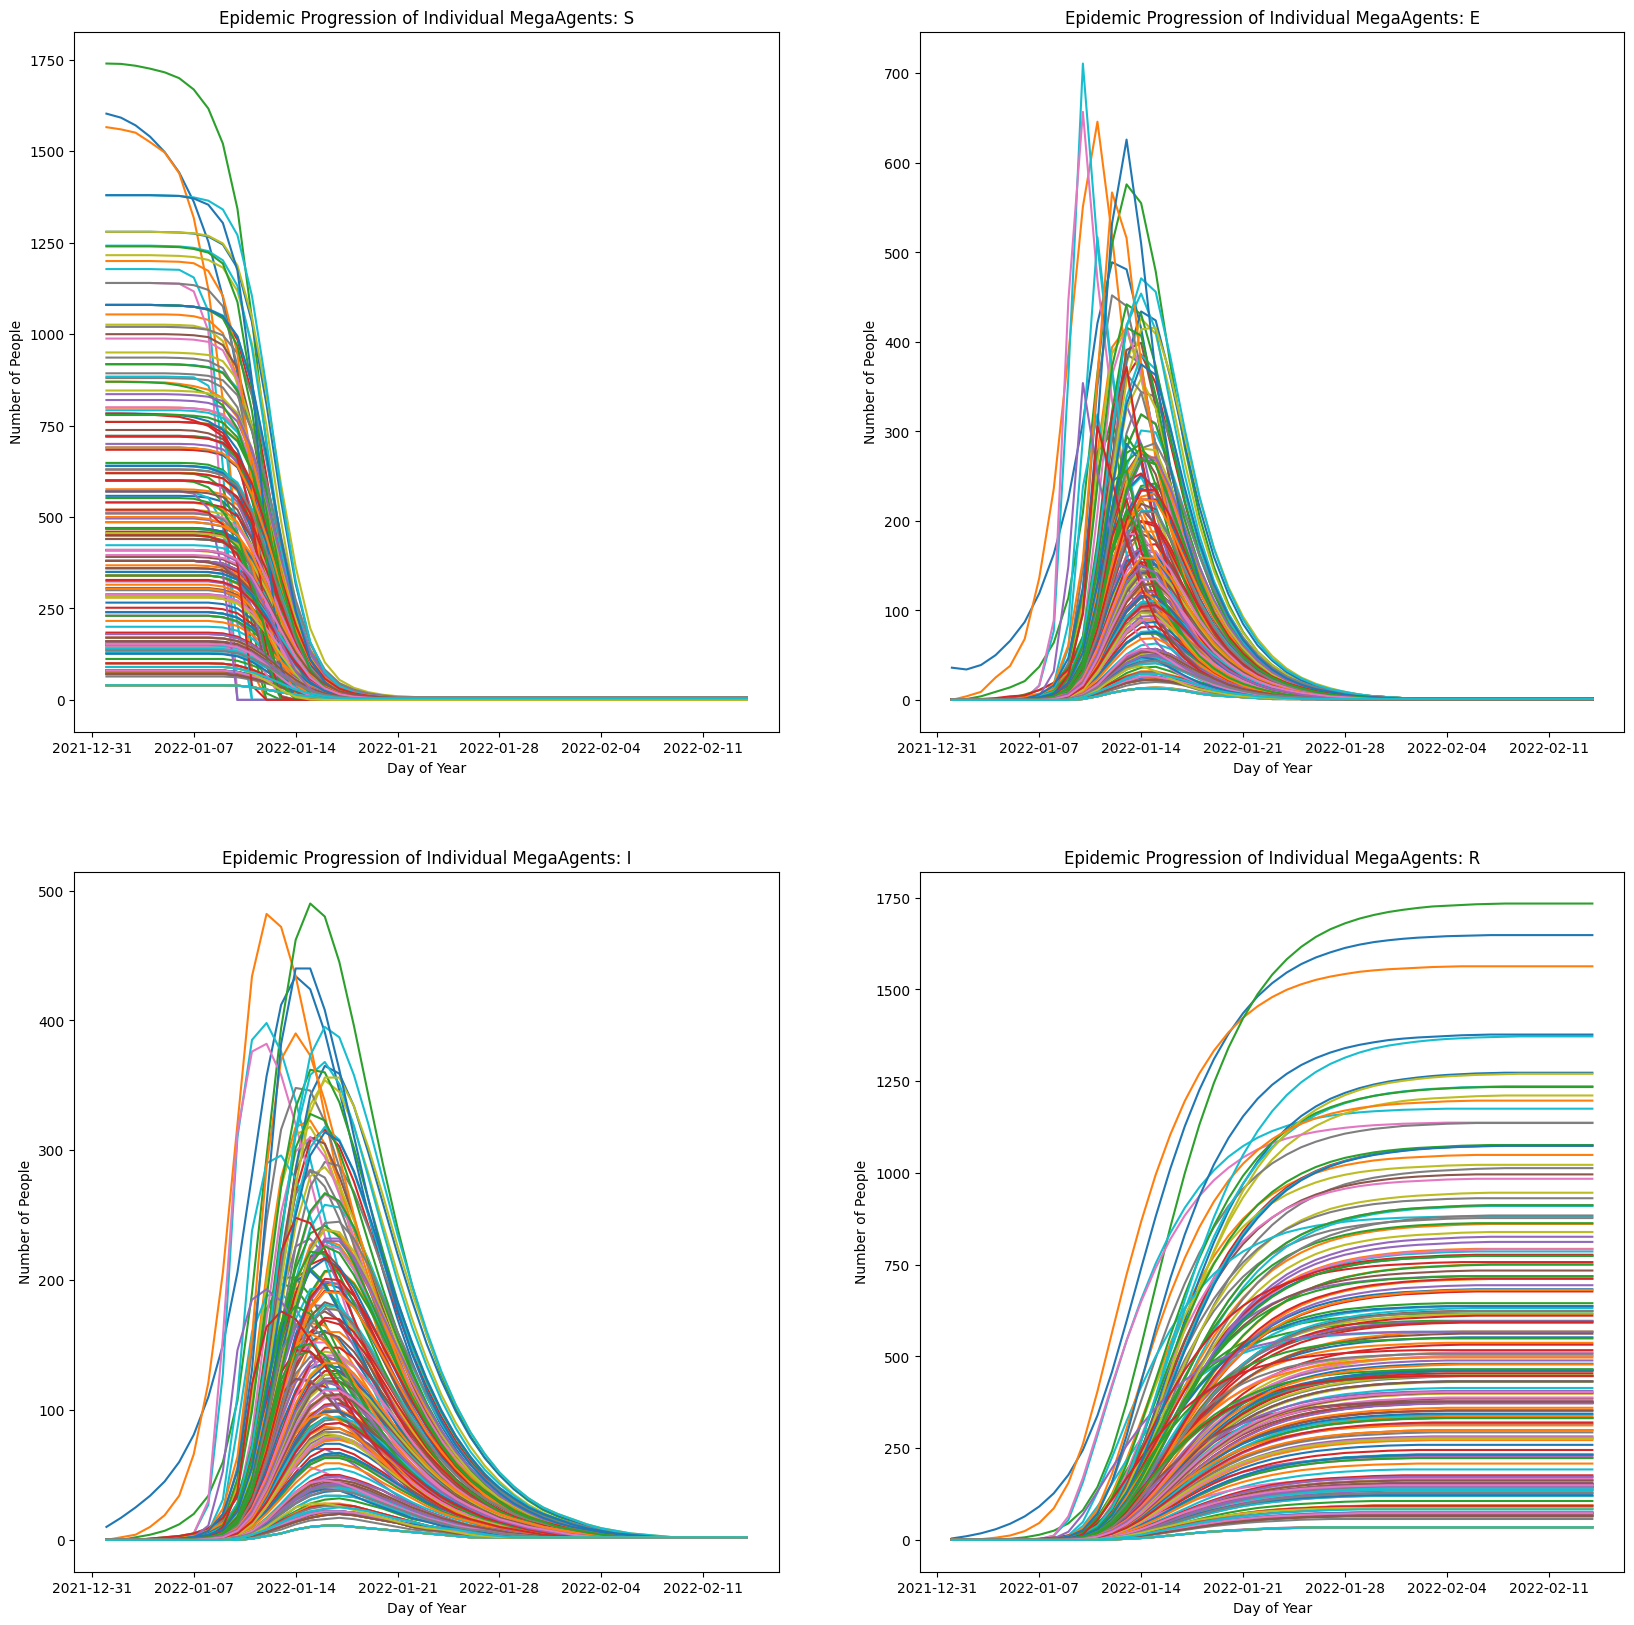

In [16]:
stat.plot_aggregated_progression(repetitions)
stat.plot_MegaAgents_progressions()

# Basic Simulation

Running 1 repetitions.
Initial exposed: 50
Simulation days: 45 days, 0:00:00


Overall Progress: 100%|████████████████████████████████████████████████████████████████| 45/45 [00:47<00:00,  1.05s/it]


Average final exposure count is 97816.0
CPU times: total: 52.7 s
Wall time: 52.7 s


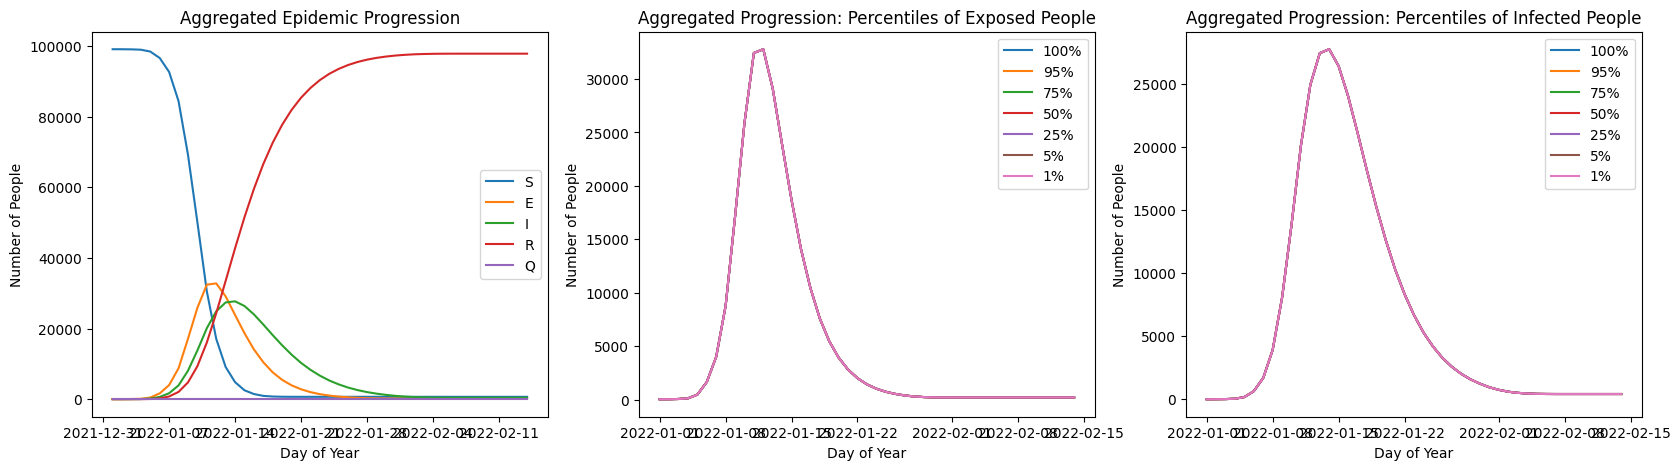

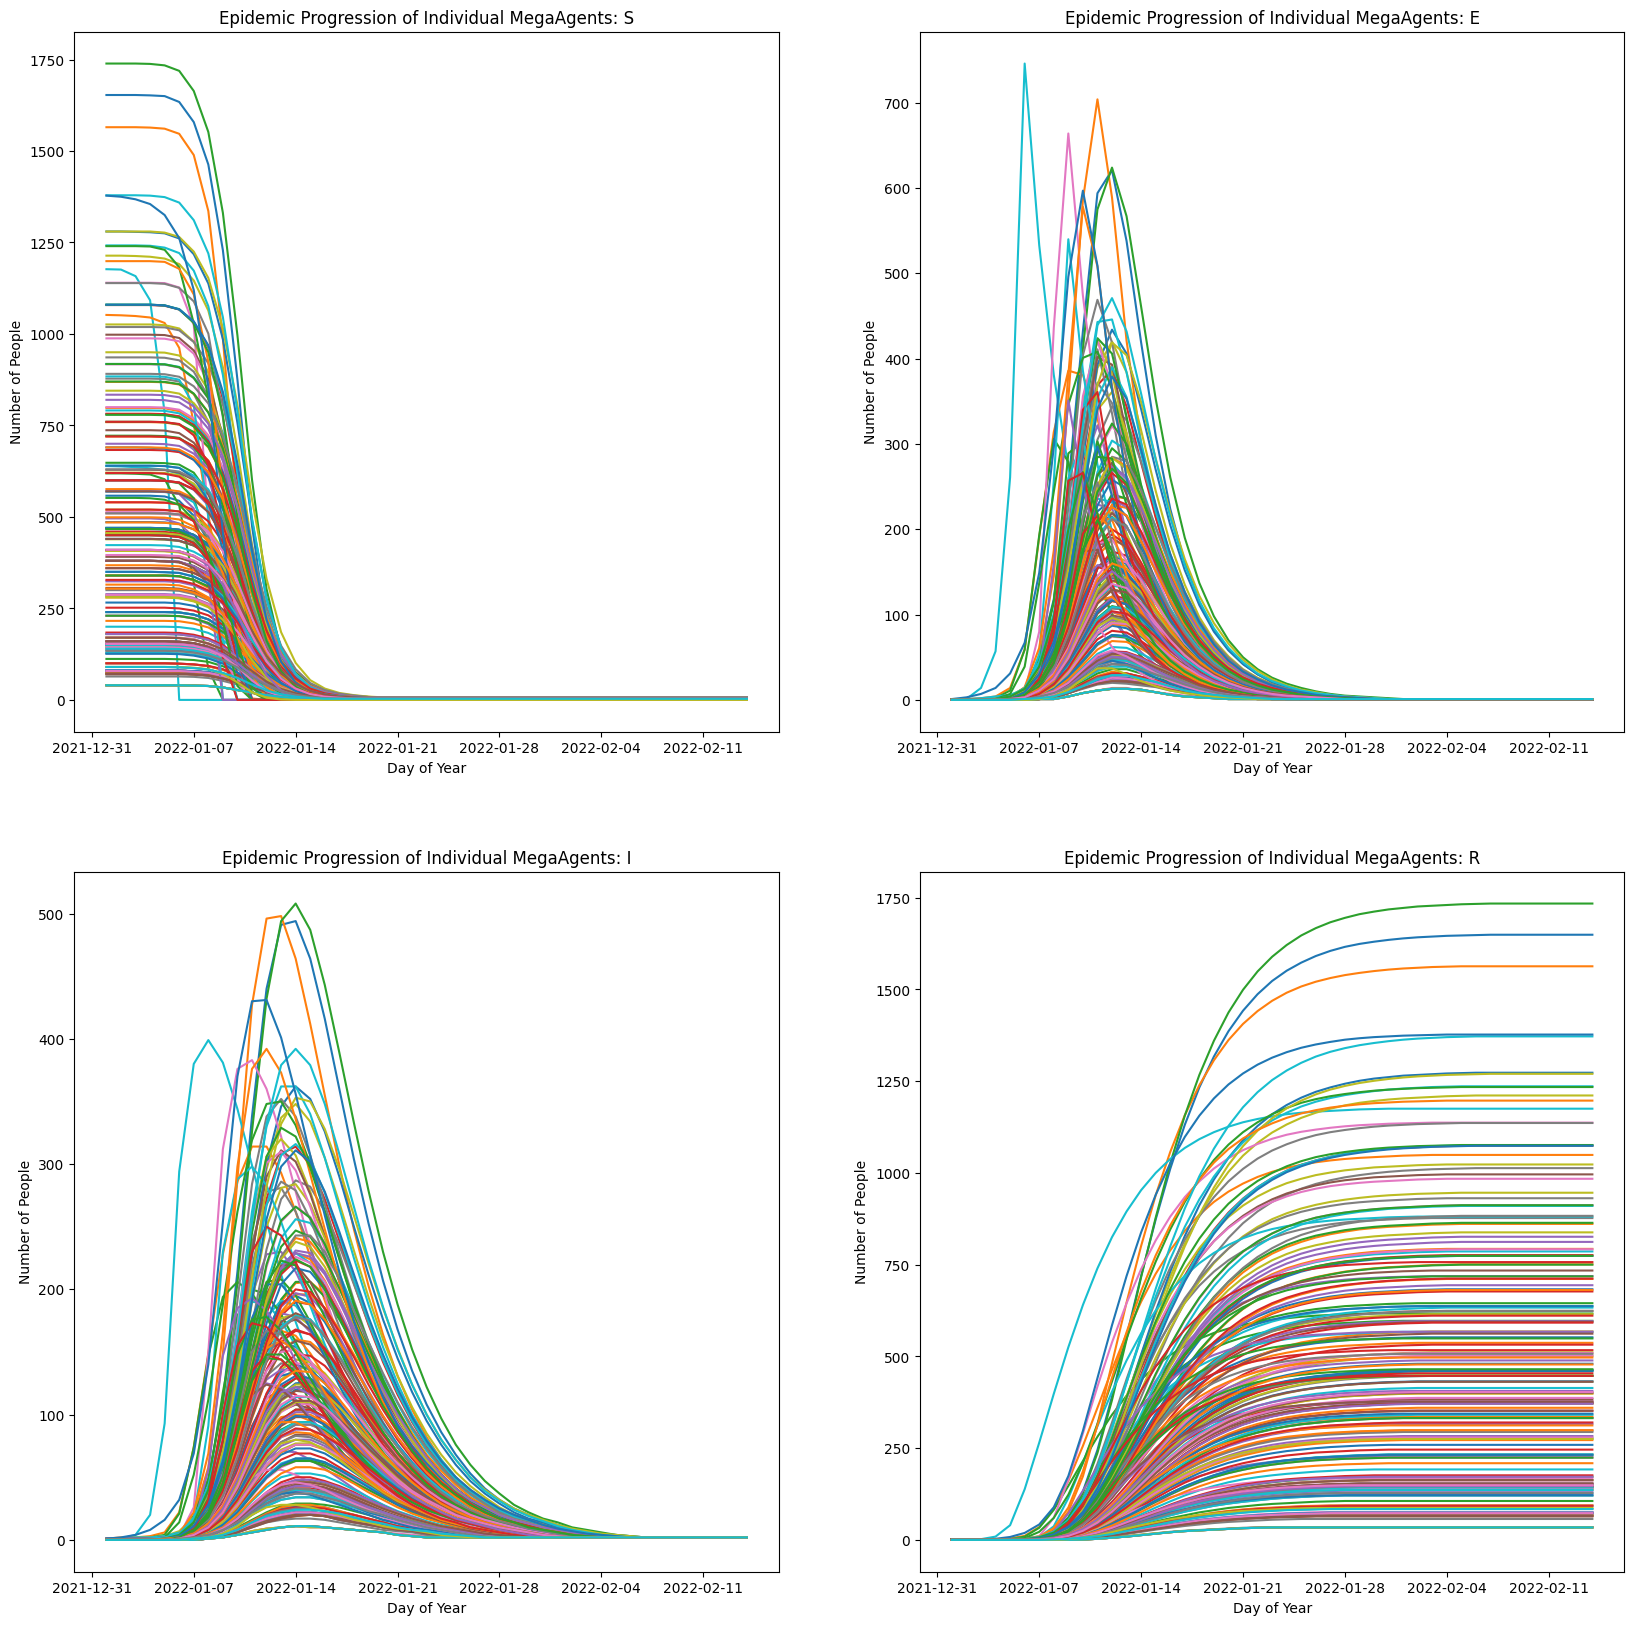

In [5]:
%%time

# specify how many times you wanna run simulation
repetitions = 1
initial_exposed_count = 50
# discount percentage of hazard brought by an asymptomatic individual
asym_hazard_multiplier = 0.5
parameters = Parameters(repetitions, initial_exposed_count, asym_hazard_multiplier)
parameters.infection_duration = VariedInfectionDurationResponse(rate_from_S_to_E=5,
                                                             rate_from_E_to_I=1/3.5, 
                                                             rate_from_asymI_to_R=1/4, 
                                                             rate_from_symI_to_R=1/4, 
                                                             asym_fraction=0, 
                                                             asym_hazard_multiplier=asym_hazard_multiplier)


# Create simulation_period_basic_info object
simulation_period_basic_info = SimulationPeriodBasicInfo(dates,
                                                      facility_date_time_step_urbano_agent_dic,
                                                      urbano_agent_date_time_step_facility_dic,
                                                      urbano_agents_travelers_mapping,
                                                      traveler_urbano_agent_mapping,
                                                      time_use_baseline_dict,
                                                      county_mobility_changes_dict,
                                                      stationary_distributions,
                                                      facility_to_index)


simulation = Simulation(dates, 
                     simulation_period_basic_info, 
                     parameters, 
                     simulation_period_basic_info.AllFacilityNames)

simulation.run()

# Testing & Contact Tracing & Quarantine

Running 1 repetitions.
Initial exposed: 50
Simulation days: 45 days, 0:00:00


Overall Progress: 100%|████████████████████████████████████████████████████████████████| 45/45 [02:18<00:00,  3.08s/it]


Average final exposure count is 31376.0
CPU times: total: 2min 27s
Wall time: 2min 28s


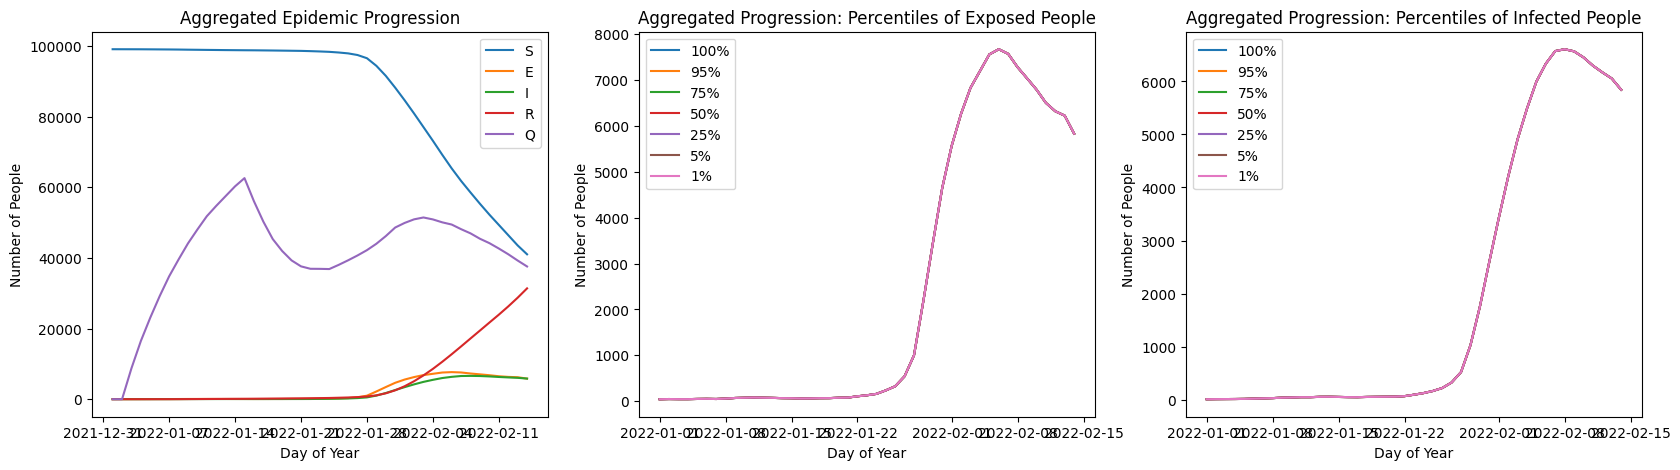

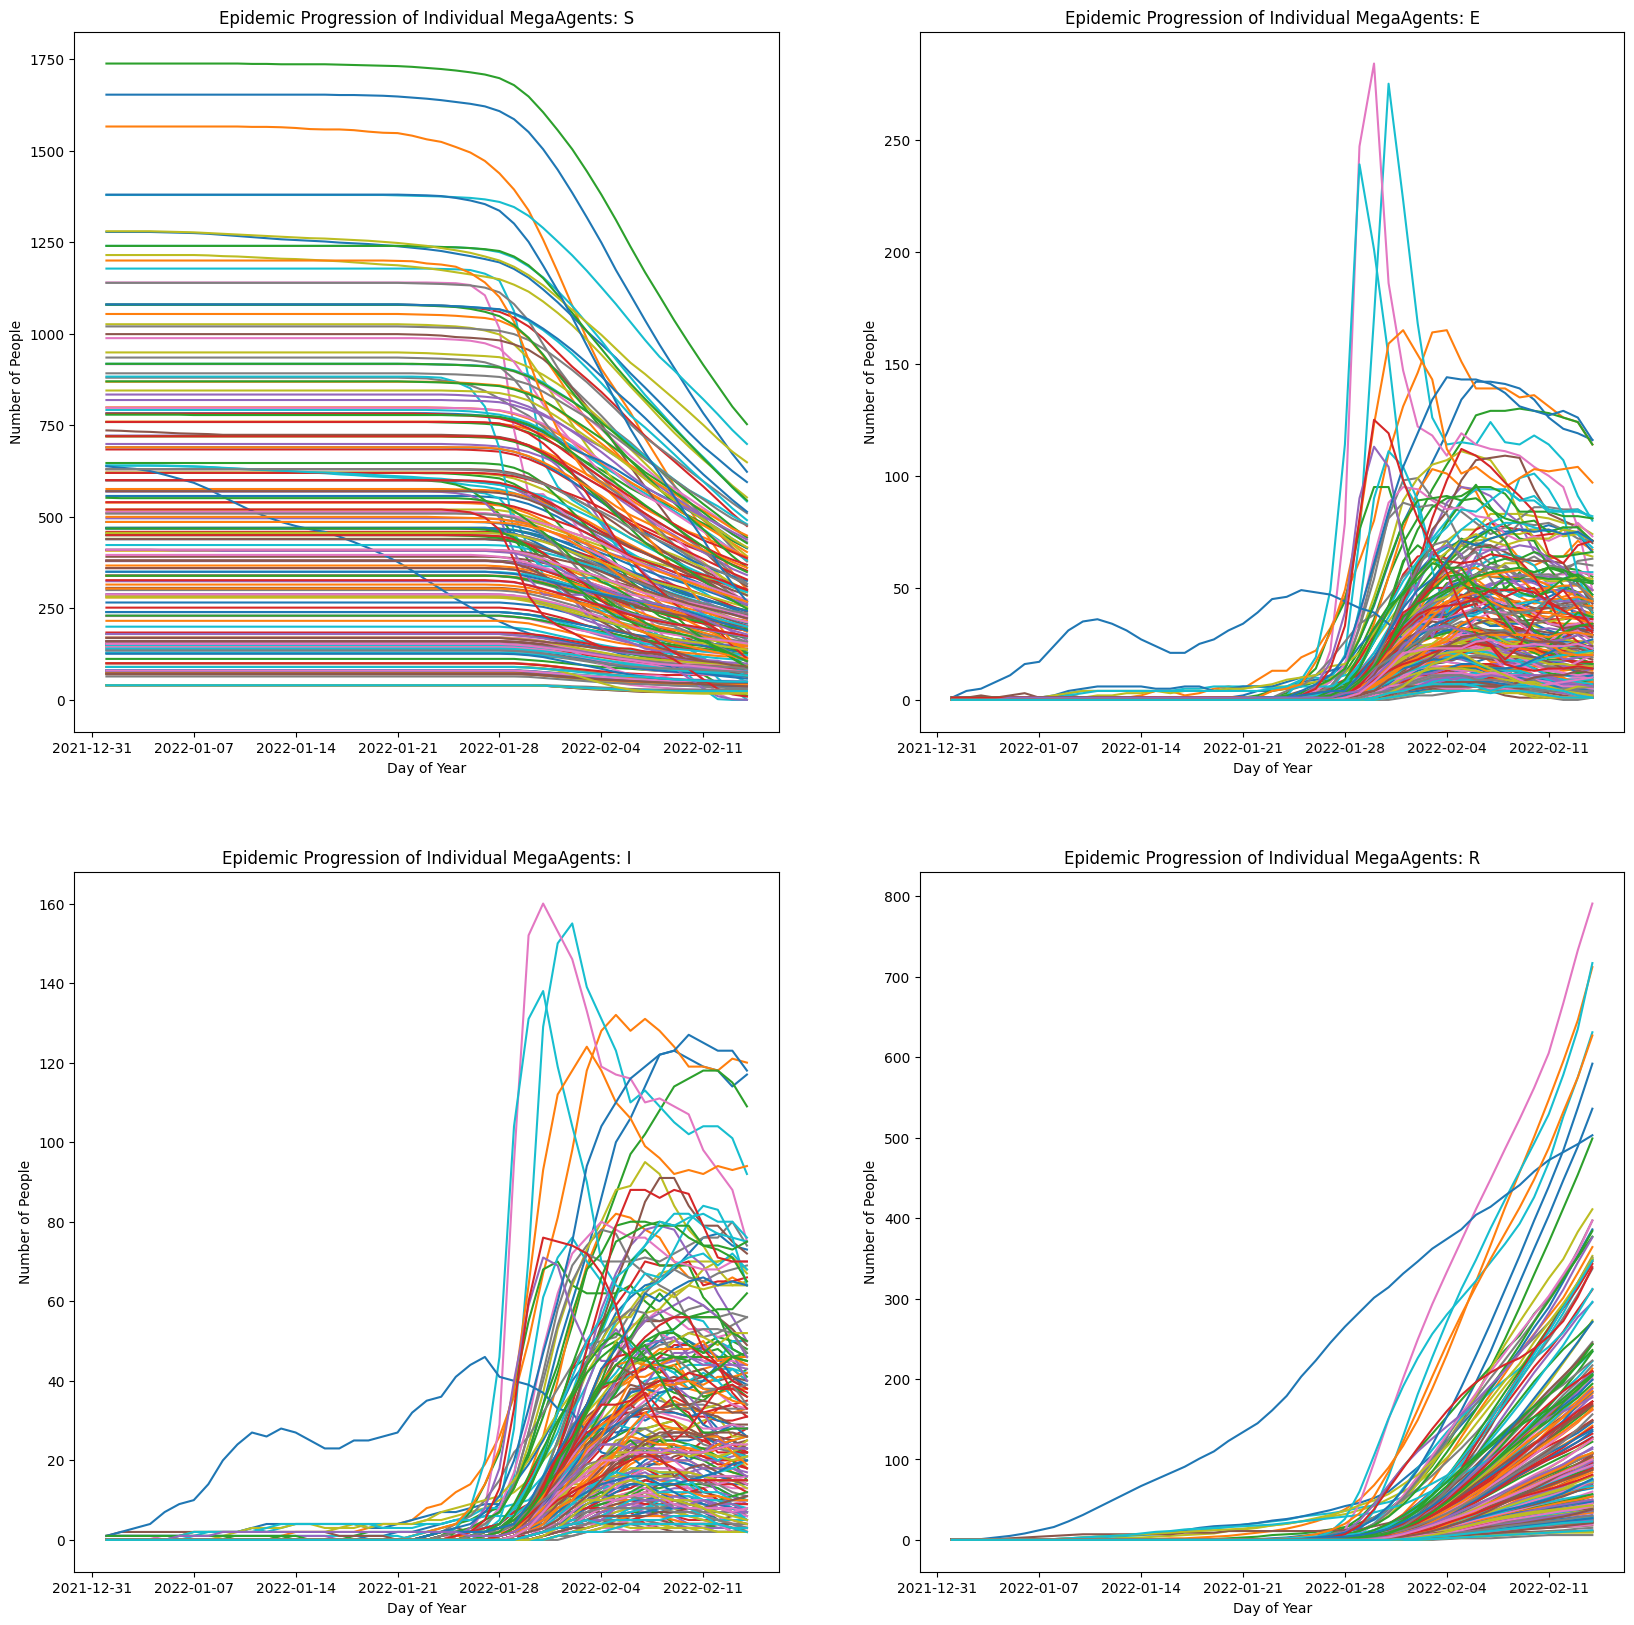

In [6]:
%%time

with cProfile.Profile() as pr: 

    # specify how many times you wanna run simulation
    repetitions = 1
    initial_exposed_count = 50
    # discount percentage of hazard brought by an asymptomatic individual
    asym_hazard_multiplier = 0.5
    parameters = Parameters(repetitions, initial_exposed_count, asym_hazard_multiplier)
    parameters.infection_duration = VariedInfectionDurationResponse(rate_from_S_to_E=5,
                                                                 rate_from_E_to_I=1/3.5, 
                                                                 rate_from_asymI_to_R=1/4, 
                                                                 rate_from_symI_to_R=1/4, 
                                                                 asym_fraction=0, 
                                                                 asym_hazard_multiplier=asym_hazard_multiplier)


    # Create simulation_period_basic_info object
    simulation_period_basic_info = SimulationPeriodBasicInfo(dates,
                                                          facility_date_time_step_urbano_agent_dic,
                                                          urbano_agent_date_time_step_facility_dic,
                                                          urbano_agents_travelers_mapping,
                                                          traveler_urbano_agent_mapping,
                                                          time_use_baseline_dict,
                                                          county_mobility_changes_dict,
                                                          stationary_distributions,
                                                          facility_to_index)


    simulation = Simulation(dates, 
                         simulation_period_basic_info, 
                         parameters, 
                         simulation_period_basic_info.AllFacilityNames)


    # enable this block if conduct testing
    parameters.probs_to_be_tested = {"S":0.1,"E":0.4,"Is":0.8,"Ia":0.4,"R":0.1} 
    parameters.test_accuracy_rate = 0.8
    parameters.prob_of_self_report = 0.2
    parameters.quarantine_prob = 0.1
    parameters.conduct_testing = GeneralTesting(parameters.probs_to_be_tested, 
                                             parameters.test_accuracy_rate,
                                             parameters.prob_of_self_report)


    # # enable this line if conduct contact tracing
    # parameters.contact_tracing = ContactTracing(parameters.contact_trace_date_length, 
    #                                             parameters.quarantine_length)

    simulation.run()

In [7]:
st = pstats.Stats(pr)
st.sort_stats(pstats.SortKey.TIME)
st.print_stats()

         158062439 function calls (158049199 primitive calls) in 148.252 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 13890228   62.764    0.000   62.764    0.000 {method 'remove' of 'list' objects}
    56591   18.776    0.000   18.781    0.000 C:\Users\Administrator.DESKTOP-D3SVMI5\Desktop\Hybrid SEIR  Modeling\PySeirCity_Hybrid_deterministic_V11\SEIRCityModeling\megaagent.py:139(calculate_MegaAgent_risk)
    56591   11.926    0.000   12.441    0.000 C:\Users\Administrator.DESKTOP-D3SVMI5\Desktop\Hybrid SEIR  Modeling\PySeirCity_Hybrid_deterministic_V11\SEIRCityModeling\megaagent.py:155(calculate_susceptible_travelers_risks)
  3802125    9.453    0.000   74.282    0.000 C:\Users\Administrator.DESKTOP-D3SVMI5\Desktop\Hybrid SEIR  Modeling\PySeirCity_Hybrid_deterministic_V11\SEIRCityModeling\megaagent.py:412(initiate_quarantine)
   272160    9.193    0.000    9.796    0.000 C:\Users\Administrator.DESKTOP-D3SVMI5\Desktop\